Preparation of the dataset for the homemade backtest

In [91]:
import pandas as pd
import numpy as np
from numpy import int64
from matplotlib import pyplot as plt
import importlib

import sqlite_io as sio
import backtest_portfolio as bp

importlib.reload(bp)

<module 'backtest_portfolio' from 'c:\\Projets\\MarketDataEnrichment\\backtest\\backtest_portfolio.py'>

In [94]:
PATH_DATA = "C:\\Projets\\Data\\DTS_FULL\\"
df_base=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_XGB_20D_50D_V1_BT.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
df_base.drop(columns=["Unnamed: 0"],inplace=True)
df_base.describe()

,OPEN,HIGH,LOW,CLOSE,pos_sma200,adx14_pos,lab_perf_50d_20d,predict_lab_perf_50d_20d
count,535117.000000,535117.000000,535117.000000,535117.000000,535117.000000,535117.000000,535117.000000,535117.000000
mean,109.231074,111.211909,106.628116,108.664436,0.014595,25.444846,20.232942,18.581514
std,1962.747415,2073.960294,1815.080755,1921.684186,0.227099,12.538963,15.190891,15.488783
min,0.001800,0.001800,0.001600,0.001700,-0.998240,0.000000,0.000000,0.000000
25%,10.432600,10.578300,10.251200,10.412400,-0.091560,17.424930,10.000000,0.000000
50%,26.250000,26.554800,25.903300,26.218300,0.014250,23.278940,21.000000,22.000000
75%,66.453800,67.126400,65.646900,66.428100,0.112500,30.463230,33.000000,33.000000
max,299711.812500,319884.718800,244956.765600,279538.906300,11.759450,100.000000,44.000000,44.000000


In [95]:
PATH_DB_FWK="C:\\Projets\\Data\\sqlite\\dataset_market.db"
if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

df_info_stocks=sio.get_info_all_stock(con_fwk)
df_info_stocks.head()

,SK_SYMBOL,CODE,NAME,TYPE,REGION,CODE_YAHOO,TRADABLE,SHARESOUTSTANDING
0,12,2MX.PA,2MX ORGANIC,Stock,France,2MX.PA,1,None
1,13,AAA.PA,ALAN ALLMAN ASSOCIATES,Stock,France,AAA.PA,0,45675754
2,14,ABCA.PA,ABC ARBITRAGE,Stock,France,ABCA.PA,1,59608879
3,15,ABEO.PA,ABEO,Stock,France,ABEO.PA,1,7543305
4,16,ABIO.PA,ALBIOMA,Stock,France,ABIO.PA,1,32370737


In [96]:
df_base_noind=df_base.reset_index()
df_merged = df_base_noind.merge(df_info_stocks, on='CODE', how='left',validate='many_to_one')
df_merged['DAY']=df_merged['OPEN_DATETIME']
df_merged.set_index(["DAY","CODE"],inplace=True)

df_merged = df_merged[df_merged['TRADABLE'] != 0]
df_merged=df_merged[['OPEN_DATETIME','OPEN','HIGH','LOW','CLOSE','pos_sma200','adx14_pos','lab_perf_50d_20d','predict_lab_perf_50d_20d','NAME','SHARESOUTSTANDING']]

df_merged['SHARESOUTSTANDING']=df_merged['SHARESOUTSTANDING'].fillna(0)
df_merged['SHARESOUTSTANDING']=df_merged['SHARESOUTSTANDING'].replace('',0)
df_merged['SHARESOUTSTANDING']=df_merged['SHARESOUTSTANDING'].astype(int64)
df_merged['lab_perf_50d_20d'] = df_merged['lab_perf_50d_20d'].astype(str).str.zfill(2)
df_merged['predict_lab_perf_50d_20d'] = df_merged['predict_lab_perf_50d_20d'].astype(str).str.zfill(2)
df_merged['NAME']=df_merged['NAME'].astype(str)
df_merged['cap_M']=round((df_merged['CLOSE']*df_merged['SHARESOUTSTANDING'])/1000000.0,2)
df_merged['weekday']=df_merged.index.get_level_values(0).weekday
df_merged['week_YYYYWW']=df_merged.index.get_level_values(0).strftime('%Y%W')
df_merged['is_last_day_week'] = df_merged.groupby('week_YYYYWW')['OPEN_DATETIME'].transform(lambda x: x == x.max())
df_merged['code_order'] = df_merged.groupby('OPEN_DATETIME')['cap_M'].rank(ascending=False, method='first')
df_merged['next_open'] = df_merged.groupby('CODE')['OPEN'].shift(-1)

df_merged.head()



,,OPEN_DATETIME,OPEN,HIGH,LOW,CLOSE,pos_sma200,adx14_pos,lab_perf_50d_20d,predict_lab_perf_50d_20d,NAME,SHARESOUTSTANDING,cap_M,weekday,week_YYYYWW,is_last_day_week,code_order,next_open
DAY,CODE,,,,,,,,,,,,,,,,,
2017-03-01,AB.PA,2017-03-01,14.41,14.60,14.37,14.46,0.09969,21.50782,34,00,AB SCIENCE,51071069,738.49,2,201709,False,131.0,14.52
2017-03-02,AB.PA,2017-03-02,14.52,14.55,14.12,14.26,0.08529,19.96641,04,04,AB SCIENCE,51071069,728.27,3,201709,False,133.0,14.20
2017-03-03,AB.PA,2017-03-03,14.20,14.47,14.00,14.22,0.08293,18.41309,04,04,AB SCIENCE,51071069,726.23,4,201709,True,134.0,14.27
2017-03-06,AB.PA,2017-03-06,14.27,15.18,14.27,15.00,0.14265,26.52947,04,30,AB SCIENCE,51071069,766.07,0,201710,False,131.0,15.00
2017-03-07,AB.PA,2017-03-07,15.00,15.13,14.86,14.97,0.14080,25.40509,04,34,AB SCIENCE,51071069,764.53,1,201710,False,130.0,15.28


In [97]:
list_exit_code=['00','01','02','03','04','10','11','12','13','14','20','21','30','31','40','41']
list_entry_code=['44']#['44','43','34']
val_pos=1000

df_merged['exit_code'] = np.where(df_merged['predict_lab_perf_50d_20d'].isin(list_exit_code), 1, 0) 


df_merged['exit'] = ((df_merged['exit_code']==1) & (df_merged['exit_code'].shift(1)==1) & (df_merged['is_last_day_week'] ==1)).astype(int)

df_merged['entry_code'] = np.where(df_merged['predict_lab_perf_50d_20d'].isin(list_entry_code), 1, 0)
df_merged['entry_2d'] = ((df_merged['entry_code']==1) & (df_merged['entry_code'].shift(1)==1)).astype(int) 
df_merged['entry'] = (df_merged['entry_2d'] == 1) & (df_merged['is_last_day_week'] ==1) 
df_merged['entry_sma_adx'] = (df_merged['entry'] == 1) & (df_merged['pos_sma200'] > 0) & (df_merged['adx14_pos'] > 20)
df_merged['entry_sma'] = (df_merged['entry'] == 1) & (df_merged['pos_sma200'] > 0) & (df_merged['adx14_pos'] > 0)

df_merged['qtt']=np.floor(val_pos/df_merged['next_open'])
df_merged['SL_20p']=df_merged['CLOSE']*(0.8)

df_merged.head()


,,OPEN_DATETIME,OPEN,HIGH,LOW,CLOSE,pos_sma200,adx14_pos,lab_perf_50d_20d,predict_lab_perf_50d_20d,NAME,...,next_open,exit_code,exit,entry_code,entry_2d,entry,entry_sma_adx,entry_sma,qtt,SL_20p
DAY,CODE,,,,,,,,,,,,,,,,,,,,,
2017-03-01,AB.PA,2017-03-01,14.41,14.60,14.37,14.46,0.09969,21.50782,34,00,AB SCIENCE,...,14.52,1,0,0,0,False,False,False,68.0,11.568
2017-03-02,AB.PA,2017-03-02,14.52,14.55,14.12,14.26,0.08529,19.96641,04,04,AB SCIENCE,...,14.20,1,0,0,0,False,False,False,70.0,11.408
2017-03-03,AB.PA,2017-03-03,14.20,14.47,14.00,14.22,0.08293,18.41309,04,04,AB SCIENCE,...,14.27,1,1,0,0,False,False,False,70.0,11.376
2017-03-06,AB.PA,2017-03-06,14.27,15.18,14.27,15.00,0.14265,26.52947,04,30,AB SCIENCE,...,15.00,1,0,0,0,False,False,False,66.0,12.000
2017-03-07,AB.PA,2017-03-07,15.00,15.13,14.86,14.97,0.14080,25.40509,04,34,AB SCIENCE,...,15.28,0,0,0,0,False,False,False,65.0,11.976


In [98]:
df_merged['cap_filter'] = df_merged['cap_M'].where(df_merged['entry'] == 1, None)
df_merged['entry_order'] = df_merged.groupby('OPEN_DATETIME')['cap_filter'].rank(ascending=False, method='first')
df_merged['entry_filter'] = df_merged.groupby('OPEN_DATETIME')['entry_order'].rank(ascending=False, method='first') <= 50

df_merged['cap_filter_sma_adx'] = df_merged['cap_M'].where(df_merged['entry_sma_adx'] == 1, None)
df_merged['entry_order_sma_adx'] = df_merged.groupby('OPEN_DATETIME')['cap_filter_sma_adx'].rank(ascending=False, method='first')
df_merged['entry_filter_sma_adx'] = df_merged.groupby('OPEN_DATETIME')['entry_order_sma_adx'].rank(ascending=False, method='first') <= 50

df_merged['cap_filter_sma'] = df_merged['cap_M'].where(df_merged['entry_sma'] == 1, None)
df_merged['entry_order_sma'] = df_merged.groupby('OPEN_DATETIME')['cap_filter_sma'].rank(ascending=False, method='first')
df_merged['entry_filter_sma'] = df_merged.groupby('OPEN_DATETIME')['entry_order_sma'].rank(ascending=False, method='first') <= 50

df_merged.head()
# df_merged.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_XGB_20D_50D_V1_BT_PREPA.zip", sep=",")

,,OPEN_DATETIME,OPEN,HIGH,LOW,CLOSE,pos_sma200,adx14_pos,lab_perf_50d_20d,predict_lab_perf_50d_20d,NAME,...,SL_20p,cap_filter,entry_order,entry_filter,cap_filter_sma_adx,entry_order_sma_adx,entry_filter_sma_adx,cap_filter_sma,entry_order_sma,entry_filter_sma
DAY,CODE,,,,,,,,,,,,,,,,,,,,,
2017-03-01,AB.PA,2017-03-01,14.41,14.60,14.37,14.46,0.09969,21.50782,34,00,AB SCIENCE,...,11.568,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False
2017-03-02,AB.PA,2017-03-02,14.52,14.55,14.12,14.26,0.08529,19.96641,04,04,AB SCIENCE,...,11.408,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False
2017-03-03,AB.PA,2017-03-03,14.20,14.47,14.00,14.22,0.08293,18.41309,04,04,AB SCIENCE,...,11.376,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False
2017-03-06,AB.PA,2017-03-06,14.27,15.18,14.27,15.00,0.14265,26.52947,04,30,AB SCIENCE,...,12.000,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False
2017-03-07,AB.PA,2017-03-07,15.00,15.13,14.86,14.97,0.14080,25.40509,04,34,AB SCIENCE,...,11.976,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False


In [99]:
df_clean=df_merged[['OPEN_DATETIME','OPEN','LOW','CLOSE','lab_perf_50d_20d','predict_lab_perf_50d_20d','NAME','cap_M','week_YYYYWW','is_last_day_week','next_open','exit','entry','entry_sma_adx','entry_sma','qtt','SL_20p','entry_order','entry_order_sma_adx','entry_order_sma','entry_filter','entry_filter_sma_adx','entry_filter_sma']]

In [ ]:
distinct_codes = df_merged[df_merged['entry_wo_adx'] == 1].index.get_level_values(1).unique()

codes_not_in_distinct = df_merged[~df_merged.index.get_level_values('CODE').isin(distinct_codes)].index.get_level_values('CODE').unique().tolist()

print(len(codes_not_in_distinct))

df_clean = df_merged[~df_merged.index.get_level_values('CODE').isin(codes_not_in_distinct)]
df_clean.head()



In [100]:
df_clean=df_clean[['OPEN_DATETIME','OPEN','LOW','CLOSE','lab_perf_50d_20d','predict_lab_perf_50d_20d','NAME','cap_M','week_YYYYWW','is_last_day_week','next_open','exit','entry','entry_sma_adx','entry_sma','qtt','SL_20p','entry_order','entry_order_sma_adx','entry_order_sma','entry_filter','entry_filter_sma_adx','entry_filter_sma']]
df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_XGB_20D_50D_V1_BT_44_PREPA_CLEAN.zip", sep=",")

In [101]:
df_prepa_bt=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_XGB_20D_50D_V1_BT_44_PREPA_CLEAN.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
#entry, exit, price, low, sl, priority, nb_stocks
#delete day 2023-06-01
df_prepa_bt=df_prepa_bt.drop(pd.Timestamp('2023-06-01'))
df_prepa_bt=df_prepa_bt.drop(pd.Timestamp('2023-08-07'))


df_bt=df_prepa_bt[['LOW','next_open','exit','qtt','SL_20p','entry_order_sma_adx','entry_filter_sma_adx']]

df_bt = df_bt.rename(columns={'entry_filter_sma_adx': 'entry', 'next_open': 'price', 'LOW': 'low', 'SL_20p': 'sl', 'qtt': 'quantity','entry_order_sma_adx':'priority'})

df_bt.describe()

C:\Users\hebus\AppData\Local\Temp\ipykernel_19292\93395059.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_prepa_bt=df_prepa_bt.drop(pd.Timestamp('2023-06-01'))
C:\Users\hebus\AppData\Local\Temp\ipykernel_19292\93395059.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_prepa_bt=df_prepa_bt.drop(pd.Timestamp('2023-08-07'))


,low,price,exit,quantity,sl,priority
count,471482.000000,471184.000000,471482.000000,471184.000000,471482.000000,3023.000000
mean,85.731242,88.189808,0.106362,234.925346,70.403762,10.629176
std,1900.685803,2033.656815,0.308301,3663.726368,1612.884208,9.844746
min,0.001600,0.001800,0.000000,0.000000,0.001360,1.000000
25%,11.138400,11.339800,0.000000,15.000000,9.052320,3.000000
50%,26.532600,26.900000,0.000000,37.000000,21.493160,7.000000
75%,64.432300,65.148625,0.000000,88.000000,52.087780,15.000000
max,244956.765600,299711.812500,1.000000,555555.000000,223631.125040,47.000000


In [104]:
initial_cash = 10000
commission = 0.005
freq_print=20
log_to_file=True

options = {'max_positions': 10, 'scale_up': False, 'sell_all': False, 'fixe_quantity':False}

remaining_portfolio = bp.backtest_strategy_portfolio(df_in=df_bt, initial_cash=initial_cash, commission=commission,options=options,freq_print=freq_print,log_to_file=log_to_file)
print(f'Remaining portfolio: {remaining_portfolio}')
print(f'{remaining_portfolio.nb_trades= } {remaining_portfolio.total_commission= }')


# CAC40 GR au 2017-03-03 : 12000 
# CAC40 GR au 2023-10-19 : 20902 soit 74.18% de perf

# PTF au 2017-03-03 : 10000
# PTF 44 SMA ADX  au 2023-10-19 :  10833+XFAB 124*9.03 + ESI 6*148 + QDT 51*18.78 + BSD 183*5.7 + IVA 252*3.4 + IAM 104*9.35 =  10833 + 1119.72 + 888 + 957.78 + 1043.1 + 856.8 + 972.4 - 30 =  16638.8 soit 66.39% de perf
# PTF 44 SMA au au 2023-10-19 : 7382 + XFAB 124*9.03 + ESI 6*148 + QDT 51*18.78 + BSD 183*5.7 + IVA 252*3.4 + IAM 104*9.35 + NANO 166*5.79 =  7382 + 1119.72 + 888 + 957.78 + 1043.1 + 856.8 + 972.4 + 961,14 - 35 =  14143.94 soit 41.43% de perf
# PTF 43 34 44 SMA ADX au 2023-10-19 :  4697 + BOL 186*4.99 + XFAB 124*9.03 + ESI 6*148 + SESG 155*5.6 + QDT 51*18.78 + BSD 183*5.7 + GLE 43*21.07 +  IVA 252*3.4 + IAM 104*9.35 = 4697 + 928 + 1119 + 888 + 868 +957 + 1043 + 906 + 856 + 972 -45 = 13189 soit 31.89% de perf

2024-04-28 17:29:31,485 - Portfolio - INFO - Initial cash: 10000, max_positions: 10, scale_up: False
2024-04-28 17:29:31,485 - Portfolio - INFO - Initial cash: 10000, max_positions: 10, scale_up: False
2024-04-28 17:29:31,485 - Portfolio - INFO - Initial cash: 10000, max_positions: 10, scale_up: False
2024-04-28 17:29:31,485 - Portfolio - INFO - Initial cash: 10000, max_positions: 10, scale_up: False
2024-04-28 17:29:31,540 - Portfolio - INFO - 2017-03-03 00:00:00 Bought 12.0 of TRI.PA, cost: 933.904692, remaining cash: 9066.095308
2024-04-28 17:29:31,540 - Portfolio - INFO - 2017-03-03 00:00:00 Bought 12.0 of TRI.PA, cost: 933.904692, remaining cash: 9066.095308
2024-04-28 17:29:31,540 - Portfolio - INFO - 2017-03-03 00:00:00 Bought 12.0 of TRI.PA, cost: 933.904692, remaining cash: 9066.095308
2024-04-28 17:29:31,540 - Portfolio - INFO - 2017-03-03 00:00:00 Bought 12.0 of TRI.PA, cost: 933.904692, remaining cash: 9066.095308
2024-04-28 17:29:31,544 - Portfolio - INFO - 2017-03-03 00:0

Logging to file: c:\Projets\MarketDataEnrichment\backtest/logs/


2024-04-28 17:29:31,679 - Portfolio - INFO - 2017-03-24 00:00:00 Sold  12.0 of IPN.PA, revenue: 1017.560232, remaining cash: 1021.0096319999996
2024-04-28 17:29:31,679 - Portfolio - INFO - 2017-03-24 00:00:00 Sold  12.0 of IPN.PA, revenue: 1017.560232, remaining cash: 1021.0096319999996
2024-04-28 17:29:31,679 - Portfolio - INFO - 2017-03-24 00:00:00 Sold  12.0 of IPN.PA, revenue: 1017.560232, remaining cash: 1021.0096319999996
2024-04-28 17:29:31,686 - Portfolio - WARNING - 2017-03-24 00:00:00 Not enough cash to buy 35.0 of AKW.PA
2024-04-28 17:29:31,686 - Portfolio - WARNING - 2017-03-24 00:00:00 Not enough cash to buy 35.0 of AKW.PA
2024-04-28 17:29:31,686 - Portfolio - WARNING - 2017-03-24 00:00:00 Not enough cash to buy 35.0 of AKW.PA
2024-04-28 17:29:31,686 - Portfolio - WARNING - 2017-03-24 00:00:00 Not enough cash to buy 35.0 of AKW.PA
2024-04-28 17:29:31,689 - Portfolio - WARNING - 2017-03-24 00:00:00 Not enough cash to buy 254.0 of DBG.PA
2024-04-28 17:29:31,689 - Portfolio -

Remaining portfolio: Portfolio: cash=6788.23, nb_positions=5, value=13660.47, positions=QDT.PA: 77.0 at 19.56
BSD.PA: 280.0 at 5.49
IAM.PA: 132.0 at 9.6
ESI.PA: 8.0 at 149.74
DEEZR.PA: 556.0 at 2.45 
remaining_portfolio.nb_trades= 821 remaining_portfolio.total_commission= 6524.733302499999


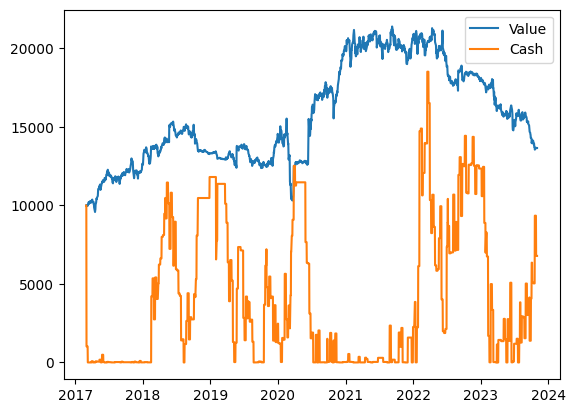

In [105]:
# print graphic history of portfolio with matplotlib
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'], label='Value')
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['cash'], label='Cash')
# plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'] - remaining_portfolio.history['cash'], label='Invested')
plt.legend()
plt.show()


